In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import scale
import seaborn as sns
from scipy import stats

In [90]:
blood=pd.read_csv('E:blood.csv')

In [91]:
blood.head()

,id,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [92]:
blood.var()

id                             4.706634e+04
Months since Last Donation     6.683804e+01
Number of Donations            3.294772e+01
Total Volume Donated (c.c.)    2.059232e+06
Months since First Donation    5.869801e+02
Made Donation in March 2007    1.825000e-01
dtype: float64

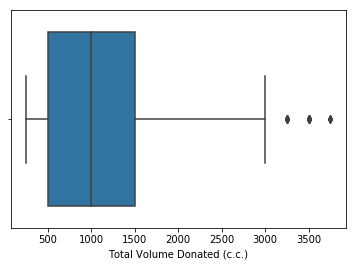

In [93]:
blood=blood[blood['Total Volume Donated (c.c.)']<4000]
sns.boxplot(blood['Total Volume Donated (c.c.)'])

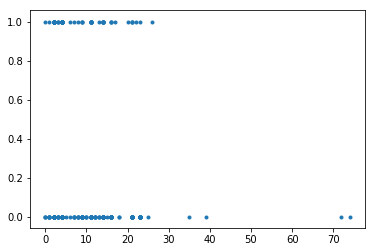

In [94]:
_=plt.scatter(blood['Months since Last Donation'],blood['Made Donation in March 2007'],marker='.')

In [95]:
#blood['Months since Last Donation']=np.log(blood['Months since Last Donation'])

In [96]:
x=blood_new.drop(['Made Donation in March 2007','id'],axis=1)
y=blood_new['Made Donation in March 2007']

In [97]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

In [98]:
dt=DecisionTreeClassifier(max_depth=4)
searcherDT=GridSearchCV(dt,{'criterion':['gini','entropy'],'min_samples_leaf':np.arange(0.1,0.6)})
searcherDT.fit(x_train,y_train)
searcherDT.best_params_
predDT=searcherDT.predict(x_test)
searcherDT.score(x_test,y_test)
roc_auc_score(y_test,predDT)

0.6371370967741935

In [99]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train,y_train)
pred=knn.predict(x_test)
roc_auc_score(y_test,pred)
#searcherKNN.score(x_test,y_test)

0.7853091397849461

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [101]:
logreg=LogisticRegression(penalty='l1',C=0.1)
logreg.fit(x_train,y_train)
grid=logreg.predict(x_test)
roc_auc_score(y_test,grid)

0.5523252688172043

In [102]:
svm=SVC(probability=True)
svm.fit(x_train,y_train)
grid=svm.predict(x_test)
roc_auc_score(y_test,grid)
#searcherSVC.best_score_

0.8742473118279569

In [103]:
bc=BaggingClassifier(base_estimator=knn,n_estimators=30,n_jobs=-1)
bc.fit(x_train,y_train)
y_bc=bc.predict(x_test)
roc_auc_score(y_test,y_bc)

0.8286559139784947

In [104]:
rc=RandomForestClassifier(n_estimators=100,min_samples_leaf=0.1)
rc.fit(x_train,y_train)
y_rc=rc.predict(x_test)
roc_auc_score(y_test,y_rc)

0.5

In [105]:
dm_train=xgb.DMatrix(data=x_train,label=y_train)
dm_test=xgb.DMatrix(data=x_test,label=y_test)
params={'booster':'gblinear','max_depth':5}
xg_reg=xgb.train(params=params,dtrain=dm_train)
y_xg=xg_reg.predict(dm_test)
roc_auc_score(y_test,y_xg)

0.7530376344086022

In [106]:
abc=AdaBoostClassifier(base_estimator=dt,n_estimators=50)
abc.fit(x_train,y_train)
y_abc=abc.predict(x_test)
roc_auc_score(y_test,y_abc)

0.8781182795698924

In [107]:
gtb=GradientBoostingClassifier(n_estimators=50,max_depth=2)
gtb.fit(x_train,y_train)
y_gtb=gtb.predict(x_test)
roc_auc_score(y_test,y_gtb)

0.6631854838709678

In [108]:
classifiers=[('abc',logreg),('log',searcherDT)]
vc=VotingClassifier(estimators=classifiers,voting='soft')
vc.fit(x_train,y_train)
y_vc=vc.predict(x_test)
vc.score(x_test,y_test)
roc_auc_score(y_test,y_vc)

C:\Users\user\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6094623655913978

In [109]:
test=pd.read_csv('E:\\blood_test.csv')
#test1=test.drop(['id'],axis=1)
#dtest=xgb.DMatrix(test1)
test=test.drop('id',axis=1)

In [110]:
y_pred=abc.predict_proba(test)

In [111]:
sub=pd.read_csv('E:\\BloodDonationSubmissionFormat.csv')
final=pd.DataFrame(y_pred)
final.columns=['id','Made Donation in March 2007']
final=final[['id','Made Donation in March 2007']]
sub['Made Donation in March 2007']=y_pred
sub.head()

,id,Made Donation in March 2007
0,659,0.425091
1,276,0.745128
2,263,0.511223
3,303,0.803090
4,83,0.284658


In [113]:
sub.to_csv('E:\\result.csv')

In [114]:
sub

,id,Made Donation in March 2007
0,659,0.425091
1,276,0.745128
2,263,0.511223
3,303,0.803090
4,83,0.284658
5,500,0.209190
6,530,0.502664
7,244,0.808352
8,249,0.995075
9,728,0.960982
